In [1]:
import os
import sys
# sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '\\ultils')
# os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import prince
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *
from plots import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core_old import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

# myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
# sns.set(style="whitegrid", font=myfont.get_name())
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

c:\Users\USER\Desktop\TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數', '經度', '緯度',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
]

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)

    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    # 台灣範圍
    dist_df = dist_df[
        (dist_df["緯度"] >= 20) & (dist_df["緯度"] <= 26) &
        (dist_df["經度"] >= 119) & (dist_df["經度"] <= 123.5)
    ]
    # 速限範圍
    dist_df = dist_df[dist_df['速限-第1當事者'] < 200]

    dist_df.drop(columns=['經度', '緯度'], inplace=True)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

dist_dfA2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] != '未紀錄']
dist_dfA1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] != '未紀錄']
car_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '車的狀態']
car_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '車的狀態']

car_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
car_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

car_A2 = car_A2[car_A2['肇因研判大類別名稱-主要'] != '非駕駛者']
car_A1 = car_A1[car_A1['肇因研判大類別名稱-主要'] != '非駕駛者']
car_A2 = car_A2[car_A2['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)']
car_A1 = car_A1[car_A1['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)']
# 刪掉原因為類似於他提供不了更多資訊，但會使Mapper更加分散
car_A2 = car_A2[car_A2['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)']
car_A1 = car_A1[car_A1['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)']

car_A2 = car_A2[car_A2['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
car_A1 = car_A1[car_A1['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']

car_A2 = car_A2[car_A2['車輛撞擊部位大類別名稱-最初'] != '未紀錄']
car_A1 = car_A1[car_A1['車輛撞擊部位大類別名稱-最初'] != '未紀錄']


C:\Users\USER\AppData\Local\Temp\ipykernel_10912\653636068.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_10912\653636068.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)


篩選掉未紀錄資料以及分類人的狀態以及車的狀態

In [4]:
from sklearn.utils import resample

sampling_ratio = 0.33  # 下採樣比例

# 計算 A1 和 A2 原始數據量比例
A1_total = len(car_A1)
A2_total = len(car_A2)
total_ratio = A1_total / A2_total  # 保留 A1/A2 的比例

# 定義函數，按月份進行下採樣
def downsample_by_month_simple(A1, A2, sampling_ratio, total_ratio):
    A1_downsampled = pd.DataFrame()
    A2_downsampled = pd.DataFrame()

    months = sorted(set(A1['發生月份']).intersection(A2['發生月份']))  # 確保月份匹配

    for month in months:
        # 提取該月份的資料
        A1_month = A1[A1['發生月份'] == month]
        A2_month = A2[A2['發生月份'] == month]

        # 計算該月份目標數量
        A1_target = int(len(A1_month) * sampling_ratio)
        A2_target = int(A1_target / total_ratio)
        print(A1_target)
        print(A2_target)

        # 下採樣
        A1_sampled = resample(A1_month, replace=False, n_samples=A1_target, random_state=42)
        A2_sampled = resample(A2_month, replace=False, n_samples=A2_target, random_state=42)

        # 合併到最終結果
        A1_downsampled = pd.concat([A1_downsampled, A1_sampled])
        A2_downsampled = pd.concat([A2_downsampled, A2_sampled])

    return A1_downsampled.reset_index(drop=True), A2_downsampled.reset_index(drop=True)

# 下採樣
downsampled_A1, downsampled_A2 = downsample_by_month_simple(car_A1, car_A2, sampling_ratio, total_ratio)
# Concat
rbind_data = pd.concat([downsampled_A1, downsampled_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

44
10105
45
10334
40
9186
35
8038
36
8267
39
8956
47
10794
43
9875
40
9186
46
10564


In [5]:
bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (95720, 145)


# Kmode

In [57]:
from kmodes.kmodes import KModes

data_for_kmode = rbind_data.drop(['死亡', '受傷'], axis=1)


cost = []
all_results = {}
K = range(1, 10)

for k in K:
    
    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=5
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

Best run was number 1
Best run was number 4
Best run was number 8
Best run was number 2
Best run was number 9
Best run was number 9
Best run was number 3
Best run was number 4
Best run was number 7


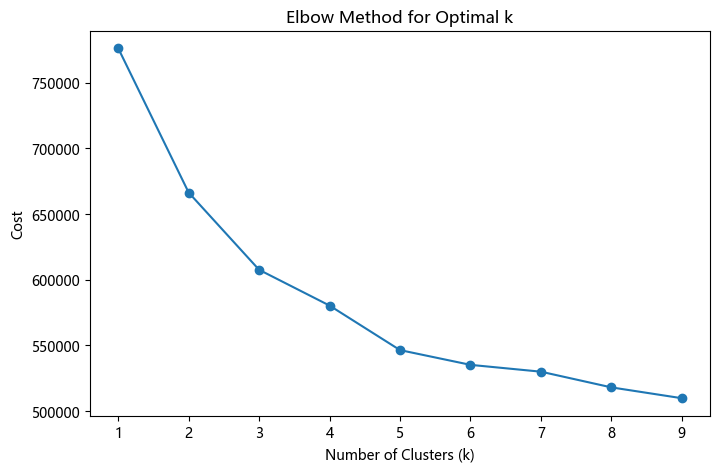

In [58]:
plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [69]:
pd.Series(all_results[3]['labels']).value_counts()
rbind_data['Cluster'] = all_results[3]['labels']

# MCA

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.123         2.99%                      2.99%
1              0.119         2.90%                      5.89%
2              0.089         2.16%                      8.05%
3              0.076         1.86%                      9.91%
4              0.075         1.83%                     11.74%
5              0.072         1.76%                     13.50%
6              0.067         1.63%                     15.12%


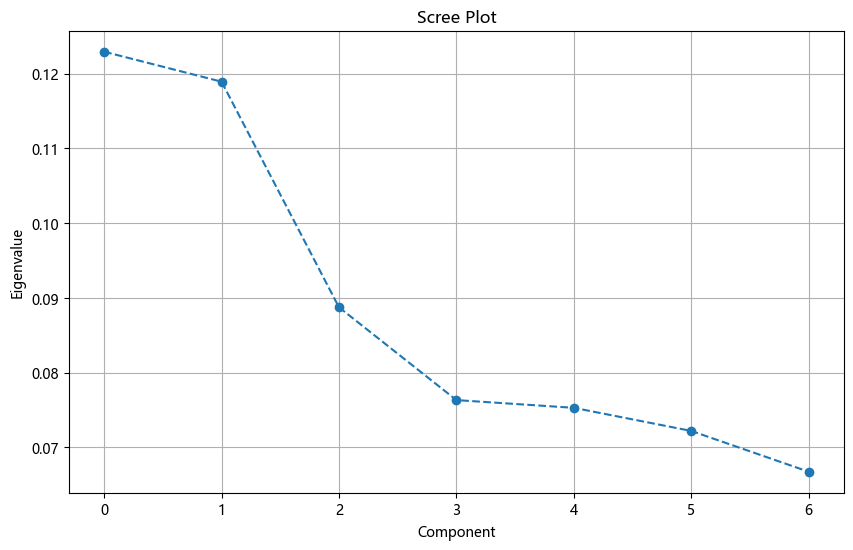

In [6]:
mca = prince.MCA(
    one_hot=False,
    n_components=7,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
    # random_state=43
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [ ]:
col_coordinate = mca.column_coordinates(data_to_map)

col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

# Normalize the 'dummy_index' for mapping to colormap
norm = plt.Normalize(vmin=col_coordinate['dummy_index'].min(), vmax=col_coordinate['dummy_index'].max())
cmap = cm.viridis  # 選擇漸層色盤，例如 viridis, plasma, inferno 等

plt.figure(figsize=(20, 12))
plt.gca().set_facecolor('white')

# 繪製散點圖，顏色根據 dummy_index 映射
scatter = plt.scatter(
    col_coordinate[0],  # X coordinate
    col_coordinate[1],  # Y coordinate
    c=col_coordinate['dummy_index'],  # 使用索引作為顏色映射
    cmap=cmap,
    alpha=0.7
)

# Adding labels with colors matching the scatter plot
offset = 0.15
for i, label in enumerate(col_coordinate.index):
    plt.text(
        col_coordinate.iloc[i, 0],  # X coordinate
        col_coordinate.iloc[i, 1] + offset,  # Y coordinate
        str(label),  # 假設 label 包含中文
        fontsize=10,
        ha='center', 
        va='center',
        color=cmap(norm(col_coordinate.iloc[i]['dummy_index'])),  # 文字顏色與點顏色一致
        # rotation=30
    )

# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label("Field Index (Gradient)", fontsize=12)

# Axes lines and grid
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# plt.title("MCA", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(True)

plt.show()

In [7]:
Overlap = [2]
Interval = [14]

In [8]:
detailed_results = []

for overlap in Overlap:
    silhouette_for_intervals = []

    for interval in Interval:
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=10
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            # filename = f"C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component7Car/results_o{overlap}i{interval}_new.pkl"
            # filename = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o{overlap}i{interval}.pkl"

            # with open(filename, 'wb') as file:
            #     pickle.dump(result, file)

            # print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 2, interval: 14


12/27/2024 01:38:34 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 143)) while a minimum of 2 is required by AgglomerativeClustering.
12/27/2024 01:38:34 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 143)) while a minimum of 2 is required by AgglomerativeClustering.
12/27/2024 01:38:34 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 143)) while a minimum of 2 is required by AgglomerativeClustering.
12/27/2024 01:38:34 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 143)) while a minimum of 2 is required by AgglomerativeClustering.
12/27/2024 01:38:35 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 143)) while a minimum of 2 is required by AgglomerativeClustering.
12/27/2024 01:38:35 AM core WARNING: Unable to perform 

In [9]:
detailed_results_df = pd.DataFrame(detailed_results)

# output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Component7Car/full_grid.pkl'
# with open(output_file, 'wb') as f:
#     pickle.dump(detailed_results_df, f)

# output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component8Car/full_grid.pkl'

# with open(output_file, 'rb') as f:
#     detailed_results_df = pickle.load(f)

# with open('Version3/GridSearch/Component7Car/results_o2i14_new.pkl', 'rb') as f:
#     detailed_results_df = pickle.load(f)

In [72]:
rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']
rbind_data['顯著特徵'].unique()

array(['直路,無號誌,陰', '四岔路,正常,晴', '四岔路,無號誌,晴', '直路,無號誌,晴', '彎曲路及附近,無號誌,晴',
       '直路,無號誌,雨', '地下道,無號誌,晴', '涵洞,無號誌,晴', '多岔路,正常,陰', '四岔路,不正常,晴',
       '三岔路,正常,晴', '三岔路,無號誌,晴', '多岔路,無號誌,雨', '橋樑,無號誌,晴', '彎曲路及附近,無號誌,陰',
       '彎曲路及附近,正常,晴', '高架道路,無號誌,晴', '多岔路,正常,晴', '彎曲路及附近,無號誌,雨',
       '四岔路,正常,陰', '三岔路,無號誌,陰', '四岔路,無號誌,雨', '圓環,無號誌,晴', '直路,正常,晴',
       '三岔路,正常,雨', '多岔路,無號誌,晴', '四岔路,無號誌,陰', '三岔路,正常,陰', '隧道,無號誌,晴',
       '直路,正常,陰', '直路,正常,雨', '其他,無號誌,晴', '四岔路,正常,雨', '坡路,無號誌,晴',
       '三岔路,無號誌,雨', '橋樑,無號誌,雨', '其他,正常,晴', '三岔路,無動作,陰', '直路,無號誌,霧或煙',
       '多岔路,正常,雨', '三岔路,無號誌,霧或煙', '坡路,無號誌,陰', '圓環,無號誌,雨', '涵洞,無號誌,雨',
       '彎曲路及附近,正常,雨', '圓環,正常,晴', '三岔路,不正常,晴', '坡路,無號誌,雨', '三岔路,無動作,晴',
       '橋樑,無號誌,陰', '四岔路,不正常,雨', '隧道,正常,晴', '高架道路,無號誌,陰', '涵洞,無號誌,陰',
       '四岔路,正常,風', '彎曲路及附近,無號誌,風', '多岔路,無號誌,陰', '其他,無號誌,陰', '圓環,無號誌,陰',
       '四岔路,無動作,陰', '四岔路,無動作,晴', '多岔路,不正常,晴', '三岔路,無號誌,風', '高架道路,正常,晴',
       '直路,無號誌,風', '四岔路,無號誌,霧或煙', '直路,無動作,晴', '坡路,正常,雨', '四岔路,無號誌,風',
       '隧道,無號誌,陰', '休息站或服務

# 目前分析使用的模型

39 seed最好 <br/>
25 的資料才是正確的

In [ ]:
choose = '天候名稱'

for i in range(15, 50):
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=i, iterations=100)
    mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    full_info = mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=10, threshold=0, range_lst=[-0.25, 0.25, 0.2, -0.2])
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000)

In [ ]:
# lst = ['Cluster', '車輛撞擊部位大類別名稱-最初', '當事者事故發生時年齡', '顯著特徵']
lst = ['當事者事故發生時年齡']

for choose in lst:
    try:
        mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=39, iterations=100)
        mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
        full_info = mapper_plotter.extract_data()
        mapper_plotter.map_colors(choose, size=10, threshold=700, range_lst=[-0.25, 0.25, 0.2, -0.2])
        # mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
        #         save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Car/o2_i14_{choose}.png")
        mapper_plotter.plot(choose, avg=False, set_label=True, size=100000)
    except Exception as e:
        print(e)
        continue

In [ ]:
lst = ['發生月份', '天候名稱',
       '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
       '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
       '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '死亡受傷人數',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱', '當事者行動狀態子類別名稱',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他',
       '肇因研判大類別名稱-個別', '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃']
lst = ['肇因研判子類別名稱-個別']

for choose in lst:
    try:
        mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'], rbind_data, seed=39, iterations=100)
        mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
        full_info = mapper_plotter.extract_data()
        mapper_plotter.map_colors(choose, size=10, threshold=700, range_lst=[-0.25, 0.25, 0.2, -0.2])
        mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                            save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Car/o2_i14_{choose}.png")
    except Exception as e:
        print(e)
        continue

In [ ]:
# choose = 'Cluster'
choose = '死亡'

unique_categories = rbind_data[choose].dropna().unique()
unique_categories.sort()

color_palette = get_cmap("tab20", len(unique_categories))
color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[39][0], rbind_data, detailed_results_df)
mplot = mapper_plotter.create_mapper_plot(choose, average_encoded_label, avg=True)
mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, size=30, threshold=0) # 篩選資料
mapper_plotter.plot(choose, unique_categories, color_palette, avg=True, 
                    set_label=True, size=100000)

In [ ]:
choose = '事故位置大類別名稱'

for index in range(detailed_results_df.shape[0]):

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[index][0], rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=30, threshold=0)
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Car/o{detailed_results_df['overlap'].iloc[index]}_i{detailed_results_df['interval'].iloc[index]}.png")


# Polygon

In [ ]:
from shapely.geometry import Point, Polygon

rectangle1 = Polygon([(0.03, -0.05), (-0.12, 0.1), (0, 0.077), (0.06, -0.05)])
rectangle2 = Polygon([(0, -0.1), (-0.09, 0.02), (-0.07, 0.05), (0.07, -0.1)])
rectangle3 = Polygon([(0.06, -0.05), (-0.01, 0.1), (0.15, 0.13), (0.15, -0.05)])
rectangle4 = Polygon([(-0.13, -0.15), (-0.13, 0), (-0.1, 0.03), (0, -0.1), (0.01, -0.15)])

# filtered_full_info = full_info[(full_info['y'] > -0.2) &
#                                (full_info['y'] < 0.2) &
#                                (full_info['x'] > -0.2) &
#                                (full_info['x'] < 0.25)]
# filtered_full_info = filtered_full_info[filtered_full_info['size'] > 0]
filtered_full_info = full_info

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)
inside_indices_3 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle3), axis=1)
inside_indices_4 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle4), axis=1)

label_0 = filtered_full_info[inside_indices_1]
label_1 = filtered_full_info[inside_indices_2]
label_2 = filtered_full_info[inside_indices_3]
label_3 = filtered_full_info[inside_indices_4]

# 提取區域內和區域外的數據
all_inside_indices = inside_indices_1 | inside_indices_2 | inside_indices_3 | inside_indices_4
outside_indices = ~all_inside_indices

label_out = filtered_full_info[outside_indices]

# assert label_0.shape[0] + label_1.shape[0] + label_out.shape[0] == filtered_full_info.shape[0]

# 繪製數據點和矩形區塊
plt.figure(figsize=(10, 8))
plt.scatter(label_0['x'], label_0['y'], label='1', color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], label='2', color='blue', s=10)
plt.scatter(label_2['x'], label_2['y'], label='3', color='purple', s=10)
plt.scatter(label_3['x'], label_3['y'], label='4', color='orange', s=10)
plt.scatter(label_out['x'], label_out['y'], color='red', s=10)

# 繪製矩形區塊
for rect, color, alpha in zip([rectangle1, rectangle2, rectangle3, rectangle4], 
                              ['green', 'blue', 'purple', 'orange'], 
                              [0.2, 0.2, 0.2, 0.2]):
    x, y = rect.exterior.xy
    plt.fill(x, y, color=color, alpha=alpha)

# 圖形調整
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

模型順序
由於1，2群體在拓樸中有過渡的性質，且是從號誌到無號誌，死亡的分布有增加的趨勢，所以使用羅吉斯 <br/>
3，4群體是從這兩個群體的雨天分割出來的，在分布上可看出較類似於不同群體，因為邊的連接較少，所以使用SVM <br/>
5、6群體是離群值以及覆蓋值，分別是群體間的不相似、相似特徵，認為在空間分布上也是類似於分群，所以使用SVM

In [169]:
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_2 = get_unique_ids(label_2)
count_3 = get_unique_ids(label_3)
count_out = get_unique_ids(label_out)

index_to_groups = {}

# 將索引與群體的關係記錄下來
for group_name, group_indexes in zip(
    ["full_0", "full_1", "full_2", "full_3", "full_out"],
    [count_0, count_1, count_2, count_3, count_out],
):
    for idx in group_indexes:
        if idx not in index_to_groups:
            index_to_groups[idx] = set()
        index_to_groups[idx].add(group_name)

# 找交集索引
intersection_indexes = {idx for idx, groups in index_to_groups.items() if len(groups) > 1}
# 移除交集的index
count_0 = [i for i in count_0 if i not in intersection_indexes]
count_1 = [i for i in count_1 if i not in intersection_indexes]
count_2 = [i for i in count_2 if i not in intersection_indexes]
count_3 = [i for i in count_3 if i not in intersection_indexes]
count_out = [i for i in count_out if i not in intersection_indexes]

full_0 = dummy_data.loc[count_0]
full_1 = dummy_data.loc[count_1]
full_2 = dummy_data.loc[count_2]
full_3 = dummy_data.loc[count_3]
full_out = dummy_data.loc[count_out]
overlap_data = dummy_data.loc[intersection_indexes]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0] + overlap_data.shape[0])
print(dummy_data.shape[0])

95715
95715


C:\Users\USER\AppData\Local\Temp\ipykernel_27384\1923563519.py:34: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



In [151]:
print(full_0['死亡'].value_counts())
print(full_1['死亡'].value_counts())
print(full_2['死亡'].value_counts())
print(full_3['死亡'].value_counts())
print(full_out['死亡'].value_counts())
print(dummy_data['死亡'].value_counts())
print(overlap_data['死亡'].value_counts())

0    51586
1      210
2        2
Name: 死亡, dtype: int64
0    29824
1      125
2        3
3        1
Name: 死亡, dtype: int64
0    4470
1      13
Name: 死亡, dtype: int64
0    2593
1       7
Name: 死亡, dtype: int64
0    4497
1      40
2       4
3       2
Name: 死亡, dtype: int64
0    95299
1      404
2        9
3        3
Name: 死亡, dtype: int64
0    2329
1       9
Name: 死亡, dtype: int64


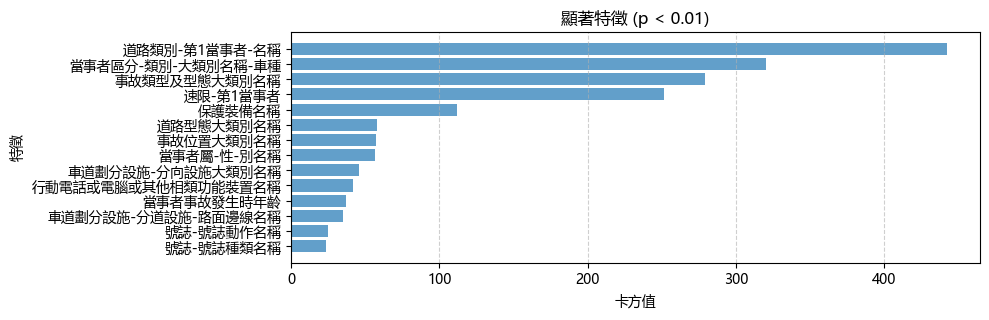

In [87]:
from scipy.stats import chi2_contingency

chi_lst = [
    '天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
    '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
    '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
    '車輛撞擊部位大類別名稱-其他']

results = []
rbind_data['death'] = rbind_data['死亡'].apply(lambda x: 1 if x >= 1 else 0)

for chi_value in chi_lst:
    contingency_table = pd.crosstab(rbind_data[chi_value], rbind_data['death'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if p < 0.01:  # 只篩選顯著結果
        results.append({'變數': chi_value, '卡方值': chi2, '自由度': dof, 'p值': p})

# 將結果轉為資料框
df_results = pd.DataFrame(results).sort_values(by='卡方值', ascending=True)

# 視覺化：條形圖
plt.figure(figsize=(10, 3.3))
plt.barh(df_results['變數'], df_results['卡方值'], alpha=0.7)
plt.xlabel('卡方值')
plt.ylabel('特徵')
plt.title('顯著特徵 (p < 0.01)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [160]:
full_0_r = rbind_data.loc[count_0]
full_1_r = rbind_data.loc[count_1]
full_2_r = rbind_data.loc[count_2]
full_3_r = rbind_data.loc[count_3]
full_out_r = rbind_data.loc[count_out]
overlap_data_r = rbind_data.loc[intersection_indexes]

# 確認所有資料都被獲取
assert len(count_0) == full_0_r.shape[0]
assert len(count_1) == full_1_r.shape[0]
assert len(count_2) == full_2_r.shape[0]
assert len(count_3) == full_3_r.shape[0]
assert len(count_out) == full_out_r.shape[0]

print(full_0_r.shape[0] + full_1_r.shape[0] + full_2_r.shape[0] + full_3_r.shape[0] + full_out_r.shape[0] + overlap_data_r.shape[0])
print(dummy_data.shape[0])

95715
95715


C:\Users\USER\AppData\Local\Temp\ipykernel_27384\531585123.py:6: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



In [161]:
plot_column = '死亡'

data_dict = {
    "無號誌、直路": full_0_r[plot_column].value_counts(normalize=True),
    "無號誌、三岔路": full_1_r[plot_column].value_counts(normalize=True),
    "正常號誌、直路": full_2_r[plot_column].value_counts(normalize=True),
    "正常號誌、四岔路": full_3_r[plot_column].value_counts(normalize=True),
    "離群值": full_out_r[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data_r[plot_column].value_counts(normalize=True),
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df

,無號誌、直路,無號誌、三岔路,正常號誌、直路,正常號誌、四岔路,離群值,覆蓋值
0,0.995907,0.995693,0.9971,0.997308,0.989875,0.996151
1,0.004054,0.004173,0.0029,0.002692,0.008805,0.003849
2,0.000039,0.000100,0.0000,0.000000,0.000880,0.000000
3,0.000000,0.000033,0.0000,0.000000,0.000440,0.000000


# 分類模型

In [ ]:
def get_train_test_data(input_data):
    input_data['y'] = input_data['死亡'].apply(lambda x: 1 if x >= 1 else 0)
    
    new_input_data = input_data.drop(columns=['受傷', '死亡'], inplace=False)
    
    X = new_input_data.drop(columns=['y'])
    y = new_input_data['y']

    return X, y

X0, y0 = get_train_test_data(full_0)
X1, y1 = get_train_test_data(full_1)
X2, y2 = get_train_test_data(full_2)
X3, y3 = get_train_test_data(full_3)
Xout, yout = get_train_test_data(full_out)
Xfull, yfull = get_train_test_data(dummy_data)
Xoverlap, yoverlap = get_train_test_data(overlap_data)

In [ ]:
matrix_0, score_0, cm_0, decision_scores_0 = logistic_cm_gridsearch(X0, y0, threshold=0.5)
matrix_1, score_1, cm_1, decision_scores_1 = logistic_cm_gridsearch(X1, y1, threshold=0.5)
matrix_2, score_2, cm_2, decision_scores_2 = logistic_cm_gridsearch(X2, y2, threshold=0.5)
matrix_3, score_3, cm_3, decision_scores_3 = logistic_cm_gridsearch(X3, y3, threshold=0.5)
matrix_out, score_out, cm_out, decision_scores_out = logistic_cm_gridsearch(Xout, yout, threshold=0.5)
matrix_overlap, score_overlap, cm_overlap, decision_scores_overlap = logistic_cm_gridsearch(Xoverlap, yoverlap, threshold=0.5)

print(matrix_0)
print(matrix_1)
print(matrix_2)
print(matrix_3)
print(matrix_out)
print(matrix_overlap)

In [ ]:
matrix_0, score_0, cm_0, decision_scores_0 = linear_svc_cm_gridsearch(X0, y0, threshold=-1.8)
matrix_1, score_1, cm_1, decision_scores_1 = linear_svc_cm_gridsearch(X1, y1, threshold=-1.8)
matrix_2, score_2, cm_2, decision_scores_2 = linear_svc_cm_gridsearch(X2, y2, threshold=-1.8)
matrix_3, score_3, cm_3, decision_scores_3 = linear_svc_cm_gridsearch(X3, y3, threshold=-1.8)
matrix_out, score_out, cm_out, decision_scores_out = linear_svc_cm_gridsearch(Xout, yout, threshold=-1.8)
matrix_overlap, score_overlap, cm_overlap, decision_scores_overlap = linear_svc_cm_gridsearch(Xoverlap, yoverlap, threshold=-1.8)

print(cm_2)
print(cm_3)
print(cm_out)
print(cm_overlap)

total_cm = cm_2 + cm_3 + cm_out + cm_overlap

total_correct = total_cm[0, 0] + total_cm[1, 1]  # True positives + True negatives
total_samples = total_cm.sum()  # Total samples
accuracy = total_correct / total_samples

print(total_cm, accuracy)

In [ ]:
full_svc_matrix, full_svc_score, full_svc_cm, full_svc_decision_scores = linear_svc_cm_gridsearch(Xfull, yfull, threshold=-1.5)
full_logit_matrix, full_logit_score, full_logit_cm, full_logit_decision_scores = logistic_cm_gridsearch(Xfull, yfull, threshold=0.5)